In [1]:
from dataclasses import dataclass
import pandas as pd
import numpy as np
import random
from decimal import Decimal
import heapq
import matplotlib.pyplot as plt 
import matplotlib
import empyrical

In [2]:
import os
os.chdir('../')

In [3]:
matplotlib.rcParams['font.sans-serif'] = ['Times New Roman'] 

#### 1.数据导入

In [4]:
redemption = pd.read_excel("./Data/强制赎回统计.xlsx") # 强制赎回统计
redemption.loc[:,"OUT_STATUS"] = True

redemption_pivot = redemption.pivot(index = "ANN_DATE",columns = "S_INFO_WINDCODE",values = "OUT_STATUS")
redemption_pivot.index = pd.to_datetime(redemption_pivot.index)

In [5]:
close_price = pd.read_excel("./Data/收盘价.xlsx",index_col = 0)
open_price = pd.read_excel("./Data/开盘价.xlsx",index_col = 0)
avg_price = pd.read_excel("./Data/均价.xlsx",index_col = 0)

In [6]:
month_begin_end = pd.read_excel("./Data/月初月末表.xlsx")

In [7]:
# 导入评级、余额、转股溢价率、上市时间、到期时间、退市时间等
rankings = pd.read_excel("./Data/债项评级.xlsx",index_col = 0)
outstanding_balance = pd.read_excel("./Data/债券余额.xlsx",index_col = 0)
important_date = pd.read_excel("./Data/重要日期.xlsx",index_col = 0)
premium = pd.read_excel("./Data/转股溢价率.xlsx",index_col = 0)

#### 2.数据清洗

In [8]:
important_date.SETUP_DATE = pd.to_datetime(important_date.SETUP_DATE)
important_date.DELIST_DATE = pd.to_datetime(important_date.DELIST_DATE)

In [9]:
# 获取债券理论存续日期
for i in important_date.index:
    mature_date = f"{important_date.at[i,'SETUP_DATE'].year + important_date.at[i,'SETUP_TERM']}-{important_date.at[i,'SETUP_DATE'].month}-{important_date.at[i,'SETUP_DATE'].day}"
    important_date.loc[i,"MATURE_DATE"] = mature_date

In [10]:
filled_close_price = close_price.asfreq("D").ffill()
filled_open_price = open_price.asfreq("D").ffill()
filled_avg_price = avg_price.asfreq("D").ffill()

filled_rankings = rankings.asfreq("D").ffill()
filled_outstanding_balance = outstanding_balance.asfreq("D").ffill()
filled_premium = premium.asfreq("D").ffill()

In [11]:
# 剔除上市之前和最后一个交易日后的市场数据
for cb in important_date.index:
    setup_date = important_date.at[cb,"SETUP_DATE"]
    delist_date = important_date.at[cb,"DELIST_DATE"]
    for df in [filled_close_price,filled_open_price,filled_avg_price,filled_rankings,filled_outstanding_balance,filled_premium,\
               close_price,open_price,avg_price,rankings,outstanding_balance,premium]:
        df.loc[:setup_date-pd.Timedelta(days = 1),cb] = np.nan # 头尾包含
        df.loc[delist_date+pd.Timedelta(days = 1):,cb] = np.nan

In [12]:
important_date.MATURE_DATE = pd.to_datetime(important_date.MATURE_DATE)

#### 3.计算双低值

In [13]:
double_low_info = 0.3*filled_close_price + 0.7*filled_premium

#### 4.获取剩余期限

In [14]:
begin_date = pd.to_datetime(filled_close_price.index[0])
end_date = pd.to_datetime(filled_close_price.index[-1])

In [15]:
backtest_date_range = pd.date_range(begin_date,end_date)

In [16]:
# 获取剩余期限
mature_date_info = pd.DataFrame(index = backtest_date_range,columns = filled_close_price.columns)

for i in mature_date_info.index:
    for j in mature_date_info.columns:
        if i >= important_date.at[j,"SETUP_DATE"] and i <= important_date.at[j,"MATURE_DATE"]:
            mature_date_info.at[i,j] = (important_date.at[j,"MATURE_DATE"] - i).days

#### 5.获取中证转债指数和次月连续

In [17]:
ic01 = pd.read_excel("./Data/IC01次月连续.xlsx",index_col = 0)
cb_index = pd.read_excel("./Data/中证转债指数.xlsx",index_col = 0)

In [18]:
# 对齐价格信息，价格信息已对齐
set(close_price.index) - set(ic01.index)

set()

In [19]:
filled_ic01 = ic01.asfreq("D").ffill()

#### 6.获取买卖操作

In [20]:
@dataclass
class ConvertibleBondObject:
    '''转债类'''
    vt_symbol:str = ""
    pct_in_equity:float = 0.0
    buy_price:float = 0.0
    volume:int = 0.0
        
    def __post_init__(self):
        self.price = self.buy_price
        self.last_price = self.price
        self.pnl = self.price/self.buy_price-1

In [21]:
@dataclass
class FutureObject:
    '''股指期货类'''
    vt_symbol:str = ""
    buy_price:float = 0.0
    volume:int = 0.0
        
    def __post_init__(self):
        self.price = self.buy_price
        self.last_price = self.price
        self.pnl = self.price/self.buy_price-1

In [22]:
'''paramaters'''
position_size:int = 20
outstanding_balance_threshold:float = 3.0
ranking_selected:list = ["AA","AA+","AAA-","AAA"]
maturity_threshold:int = 365
beta_compute_length:int = 31 # 继承joinquant的长度，可以更改
futures_margin_rate:float = 0.12 # 中证500保证金比例
futures_multiplier:int = 200 # 中证500股指期货的合约乘数
buy_cost:float = 0.0003 # 买入手续费
sell_cost:float = 0.0013 # 卖出手续费

'''variables'''
in_position_cb:dict = {} # 储存转债类
in_position_future:dict = {} # 存储股指期货类
in_position_future_num:float = 0.0 # 存储多少手指数期货
expect_in_position_future_volume:float = 0.0 # 本期期望的期货规模
expect_in_position_future_num:float = 0.0 # 本期期望的期货手数
delete_cb:list = []
capital:float = 300000.0
unhedged_capital:float = capital
daily_pnl:float = 0.0
frozen:float = 0.0
backtest_pnl_result:pd.DataFrame = pd.DataFrame(index = backtest_date_range,columns = ["NET_VALUE","UNHEDGED_NET_VALUE","PNL_RATIO_DAILY"])

'''account data'''
cb_account_balance:float = 0.0
future_account_balance:float = 0.0
cb_account_transferable_cash:float = 0.0
future_account_transferable_cash:float = 0.0

In [23]:
def compute_hedge_ratio(in_position_cb:dict,nowadays):
    # 获取收盘价序列
    portfolio_prices = close_price.loc[:nowadays].iloc[-beta_compute_length:] # 获取资产池中最近63天转债的收盘价，要包括今天
    future_index_prices = ic01.loc[:nowadays].iloc[-beta_compute_length:] # 股指期货收盘价
    
    # 获取收益率序列
    portfolio_Rets = np.zeros(shape = beta_compute_length - 1)
    for vt_symbol in in_position_cb.keys():
        portfolio_Rets += in_position_cb[vt_symbol].pct_in_equity*portfolio_prices.loc[:,vt_symbol].pct_change()[1:].values
    future_index_Rets = future_index_prices.pct_change()[1:].CLOSE.values # 同样计算指数的收益率
    
    cov_mat = np.cov(portfolio_Rets,future_index_Rets)
    beta = cov_mat[0,1]/cov_mat[1,1]
    
    return 1 + beta*futures_margin_rate + beta/5, beta

#### 7.作图和统计指标计算

In [24]:
for ix,date in enumerate(backtest_date_range[backtest_date_range>="2017-12-31"]): # 留出计算beta的空间
    """"""
    remove_cb:list = list()
    in_position_cb_daily_pnl:float = 0.0
    removed_cb_daily_pnl:float = 0.0
    future_daily_pnl:float = 0.0
    
    try:
        next_date = backtest_date_range[backtest_date_range>="2017-12-31"][ix + 1]
    except IndexError:
        next_date = date + pd.Timedelta(days = 1)
    
    # 发布赎回的转债先加入delete_cb里面
    delete_cb.extend(redemption.query("ANN_DATE == '{}'".format(date)).S_INFO_WINDCODE.tolist())
    
    # 清除触发博弈条款的转债
    for to_redemption_cb in list(in_position_cb.keys()):
        try:
            redemption_pivot.at[date,to_redemption_cb]
        except KeyError or IndexError:
            continue
        if redemption_pivot.at[date,to_redemption_cb] == True:
            print(f"sell {to_redemption_cb} at {Decimal(in_position_cb[to_redemption_cb].price).quantize(Decimal('0.0000'))} in {date}")
            delete_cb.append(to_redemption_cb)
            if not to_redemption_cb in remove_cb:
                remove_cb.append(to_redemption_cb)  

    if date.day in [28,29,30,31] and next_date.month != date.month: # 月底
        # 获取双低值最低的转债
        in_pool_cb = double_low_info.loc[date,(filled_outstanding_balance.loc[date] > outstanding_balance_threshold) & \
                                         (filled_rankings.loc[date].isin(ranking_selected)) & \
                                         (mature_date_info.loc[date] >= maturity_threshold)].dropna().sort_values().index.tolist()
        in_price_cb = close_price.loc[:date].iloc[-beta_compute_length:].dropna(axis = 1,how = "any").columns.tolist() # 至少已经上市两个月
        in_pool_cb = list(set(in_pool_cb) & set(in_price_cb))
        
        # 已经在赎回列表里的转债就不加入了
        for i in set(delete_cb) & set(in_pool_cb):
            in_pool_cb.remove(i)
        in_pool_cb = in_pool_cb[:position_size]

        # 清仓
        for to_sell_cb in (set(in_position_cb.keys()) - set(in_pool_cb)):
            print(f"sell {to_sell_cb} at {Decimal(filled_close_price.at[date,to_sell_cb]).quantize(Decimal('0.0000'))} in {date}")
            if not to_sell_cb in remove_cb:
                remove_cb.append(to_sell_cb)  
            
    elif pd.to_datetime(date) in month_begin_end.MONTH_START_TRADE.tolist(): # 假如是每个月月初的交易日
        for to_position_cb in (set(in_pool_cb) - set(in_position_cb.keys())): # 换仓
            if pd.isnull(float(Decimal(filled_avg_price.at[date,to_position_cb]).quantize(Decimal('0.0000')))):
                continue
            buy_price = float(Decimal(filled_avg_price.at[date,to_position_cb]).quantize(Decimal('0.0000')))
            print(f"buy  {to_position_cb} at {buy_price} in {date}")
            in_position_cb[to_position_cb] = ConvertibleBondObject(
                vt_symbol = to_position_cb,
                buy_price = buy_price,
                volume = np.floor((0.75*capital/position_size)/(buy_price*10))*10,
            )
            capital -= in_position_cb[to_position_cb].price*in_position_cb[to_position_cb].volume*buy_cost # 买入手续费

    # 计算每日pnl
    for vt_symbol in remove_cb:
        in_position_cb[vt_symbol].last_price = in_position_cb[vt_symbol].price
        in_position_cb[vt_symbol].price = float(Decimal(filled_close_price.at[date,vt_symbol]).quantize(Decimal('0.0000')))
        in_position_cb[vt_symbol].pnl = (in_position_cb[vt_symbol].price - in_position_cb[vt_symbol].buy_price)*in_position_cb[vt_symbol].volume
        removed_cb_daily_pnl += (in_position_cb[vt_symbol].price - in_position_cb[vt_symbol].last_price)*in_position_cb[vt_symbol].volume
        capital -= in_position_cb[vt_symbol].price*in_position_cb[vt_symbol].volume*sell_cost # 卖出手续费
        del in_position_cb[vt_symbol]
    
    total_equity:float = 0.0
    for vt_symbol in in_position_cb.keys():
        in_position_cb[vt_symbol].last_price = in_position_cb[vt_symbol].price
        in_position_cb[vt_symbol].price = float(Decimal(filled_close_price.at[date,vt_symbol]).quantize(Decimal('0.0000')))
        in_position_cb[vt_symbol].pnl = (in_position_cb[vt_symbol].price - in_position_cb[vt_symbol].buy_price)*in_position_cb[vt_symbol].volume
        in_position_cb_daily_pnl += (in_position_cb[vt_symbol].price - in_position_cb[vt_symbol].last_price)*in_position_cb[vt_symbol].volume
        total_equity += in_position_cb[vt_symbol].price*in_position_cb[vt_symbol].volume
    
    # 计算转债占权益净值比
    frozen:float = 0.0
    for vt_symbol in in_position_cb.keys():
        in_position_cb[vt_symbol].pct_in_equity = in_position_cb[vt_symbol].price*in_position_cb[vt_symbol].volume/total_equity
        frozen += in_position_cb[vt_symbol].price*in_position_cb[vt_symbol].volume
   
    # 计算对冲比例和期货手数
    hedge_ratio,beta = compute_hedge_ratio(in_position_cb = in_position_cb,nowadays = date)
    index_price = filled_ic01.at[date,"CLOSE"]
    expect_in_position_future_volume = beta*frozen
    expect_in_position_future_num = expect_in_position_future_volume/(index_price*futures_multiplier)
    print(beta)
    # 买卖股指期货
    if not "IC01" in in_position_future.keys():
        in_position_future["IC01"] = FutureObject(vt_symbol = "IC01",buy_price = index_price,volume = expect_in_position_future_num)
    else:
        in_position_future["IC01"].last_price = in_position_future["IC01"].price
        in_position_future["IC01"].price = index_price
        in_position_future["IC01"].volume = expect_in_position_future_num
        future_daily_pnl = in_position_future_num*(in_position_future["IC01"].last_price - in_position_future["IC01"].price)*futures_multiplier
    print(f"buy {expect_in_position_future_num - in_position_future_num} 'IC01' at {index_price} in {date},profit {future_daily_pnl}")
    
    in_position_future_num = expect_in_position_future_num
    capital = capital + removed_cb_daily_pnl + in_position_cb_daily_pnl + future_daily_pnl
    unhedged_capital = unhedged_capital + removed_cb_daily_pnl + in_position_cb_daily_pnl
    backtest_pnl_result.at[date,["NET_VALUE","UNHEDGED_NET_VALUE","PNL_RATIO_DAILY"]] = capital,unhedged_capital,(removed_cb_daily_pnl + in_position_cb_daily_pnl + future_daily_pnl)/capital

0.0
buy 0.0 'IC01' at 6286.2 in 2017-12-31 00:00:00,profit 0.0
0.0
buy 0.0 'IC01' at 6286.2 in 2018-01-01 00:00:00,profit 0.0
buy  128016.SZ at 117.174 in 2018-01-02 00:00:00
buy  128015.SZ at 95.9667 in 2018-01-02 00:00:00
buy  113014.SH at 118.0479 in 2018-01-02 00:00:00
buy  128010.SZ at 117.9207 in 2018-01-02 00:00:00
buy  128013.SZ at 92.7718 in 2018-01-02 00:00:00
buy  128012.SZ at 95.7901 in 2018-01-02 00:00:00
buy  127004.SZ at 93.5504 in 2018-01-02 00:00:00
buy  113011.SH at 105.5688 in 2018-01-02 00:00:00
buy  113008.SH at 99.8643 in 2018-01-02 00:00:00
buy  123001.SZ at 96.663 in 2018-01-02 00:00:00
buy  110033.SH at 117.4709 in 2018-01-02 00:00:00
buy  127003.SZ at 92.9561 in 2018-01-02 00:00:00
buy  110030.SH at 105.5655 in 2018-01-02 00:00:00
buy  113009.SH at 117.1276 in 2018-01-02 00:00:00
buy  113013.SH at 105.6729 in 2018-01-02 00:00:00
buy  113012.SH at 96.3896 in 2018-01-02 00:00:00
buy  110032.SH at 126.987 in 2018-01-02 00:00:00
buy  113010.SH at 104.0393 in 2018-

0.40020646807046456
buy -0.001327509146101552 'IC01' at 6162.0 in 2018-03-09 00:00:00,profit -1587.652354464299
0.40020646807046456
buy 0.0 'IC01' at 6162.0 in 2018-03-10 00:00:00,profit 0.0
0.40020646807046456
buy 0.0 'IC01' at 6162.0 in 2018-03-11 00:00:00,profit 0.0
0.4078962807201964
buy 0.001510805550732769 'IC01' at 6245.2 in 2018-03-12 00:00:00,profit -1194.233230234551
0.4072854231832733
buy 0.00018626166444930814 'IC01' at 6202.0 in 2018-03-13 00:00:00,profit 633.1359987339621
0.3989092128173759
buy -0.0011149778011410455 'IC01' at 6135.2 in 2018-03-14 00:00:00,profit 981.5043057312316
0.39947483728992245
buy 0.00018594167597039968 'IC01' at 6124.6 in 2018-03-15 00:00:00,profit 153.3839362943729
0.39893024727282284
buy 0.0002388243921774974 'IC01' at 6084.6 in 2018-03-16 00:00:00,profit 580.2948401790114
0.39893024727282284
buy 0.0 'IC01' at 6084.6 in 2018-03-17 00:00:00,profit 0.0
0.39893024727282284
buy 0.0 'IC01' at 6084.6 in 2018-03-18 00:00:00,profit 0.0
0.374471788077602

0.5473312084599875
buy -0.0012059307432221167 'IC01' at 5836.2 in 2018-05-28 00:00:00,profit 54.09542802715429
0.5626633675525924
buy 0.0030458900503831515 'IC01' at 5750.0 in 2018-05-29 00:00:00,profit 1772.6812524253266
0.5148408696569244
buy -0.00703541351278375 'IC01' at 5599.0 in 2018-05-30 00:00:00,profit 3197.262783422092
sell 110034.SH at 110.6700 in 2018-05-31 00:00:00
sell 110031.SH at 102.7900 in 2018-05-31 00:00:00
sell 113010.SH at 99.9100 in 2018-05-31 00:00:00
0.540464780242934
buy -0.0117629340684757 'IC01' at 5697.0 in 2018-05-31 00:00:00,profit -1937.150615516094
buy  113505.SH at 102.862 in 2018-06-01 00:00:00
buy  123009.SZ at 118.6575 in 2018-06-01 00:00:00
buy  113504.SH at 109.02 in 2018-06-01 00:00:00
0.5402345079151115
buy 0.01645157487226348 'IC01' at 5618.0 in 2018-06-01 00:00:00,profit 1375.7262399402414
0.5402345079151115
buy 0.0 'IC01' at 5618.0 in 2018-06-02 00:00:00,profit 0.0
0.5402345079151115
buy 0.0 'IC01' at 5618.0 in 2018-06-03 00:00:00,profit 0.0


0.30128315534002476
buy 0.0009259074524344268 'IC01' at 4791.0 in 2018-08-21 00:00:00,profit -552.6304442974143
0.31151038586581187
buy 0.0021258050800076617 'IC01' at 4775.0 in 2018-08-22 00:00:00,profit 210.5236341003384
0.3145867057128156
buy 0.0006579415012544637 'IC01' at 4781.8 in 2018-08-23 00:00:00,profit -92.36363940145671
0.3128329178378672
buy -0.00014402078557924913 'IC01' at 4774.8 in 2018-08-24 00:00:00,profit 96.00133513266502
0.3128329178378672
buy 0.0 'IC01' at 4774.8 in 2018-08-25 00:00:00,profit 0.0
0.3128329178378672
buy 0.0 'IC01' at 4774.8 in 2018-08-26 00:00:00,profit 0.0
0.3009921701931121
buy -0.003919206621022034 'IC01' at 4900.0 in 2018-08-27 00:00:00,profit -1713.4461707590447
0.3037988098252855
buy 0.0008165505966939157 'IC01' at 4903.8 in 2018-08-28 00:00:00,profit -49.026957671574955
0.30492244781332684
buy 0.0004162737129000116 'IC01' at 4883.0 in 2018-08-29 00:00:00,profit 271.7549345792781
0.30992239428970325
buy 0.0016807229796837742 'IC01' at 4811.0 

0.24290684633321616
buy 0.0007420167506293415 'IC01' at 4371.8 in 2018-11-07 00:00:00,profit 555.7259292249489
0.23943411905811443
buy -0.0006216152767777455 'IC01' at 4350.0 in 2018-11-08 00:00:00,profit 254.58011537930068
0.2400009927094435
buy 4.2099135247157526e-05 'IC01' at 4346.4 in 2018-11-09 00:00:00,profit 41.593189999140506
0.2400009927094435
buy 0.0 'IC01' at 4346.4 in 2018-11-10 00:00:00,profit 0.0
0.2400009927094435
buy 0.0 'IC01' at 4346.4 in 2018-11-11 00:00:00,profit 0.0
0.23939473034290637
buy -0.0013609938190714752 'IC01' at 4468.0 in 2018-11-12 00:00:00,profit -1405.9493798289302
0.2397947420640009
buy -0.0007880710244900294 'IC01' at 4558.6 in 2018-11-13 00:00:00,profit -1022.8635766407043
0.23926172205630922
buy 0.00020616077411930028 'IC01' at 4535.6 in 2018-11-14 00:00:00,profit 256.04222718068036
0.24265954891143277
buy 0.00021396777965795172 'IC01' at 4619.0 in 2018-11-15 00:00:00,profit -931.8701420109468
0.2433656399310663
buy -2.7999880004771216e-05 'IC01' a

0.3090393176551066
buy -0.0004002950512445036 'IC01' at 4185.0 in 2019-01-30 00:00:00,profit 675.4987046939434
sell 127003.SZ at 92.8970 in 2019-01-31 00:00:00
sell 110030.SH at 102.9100 in 2019-01-31 00:00:00
sell 113015.SH at 113.9800 in 2019-01-31 00:00:00
sell 113505.SH at 93.6100 in 2019-01-31 00:00:00
sell 123009.SZ at 109.0500 in 2019-01-31 00:00:00
sell 128041.SZ at 106.5830 in 2019-01-31 00:00:00
sell 123004.SZ at 91.1700 in 2019-01-31 00:00:00
sell 123015.SZ at 95.4000 in 2019-01-31 00:00:00
sell 123002.SZ at 106.7200 in 2019-01-31 00:00:00
sell 127006.SZ at 99.6040 in 2019-01-31 00:00:00
sell 110031.SH at 108.7900 in 2019-01-31 00:00:00
sell 123001.SZ at 100.2280 in 2019-01-31 00:00:00
0.3440978797788519
buy -0.04478995598873846 'IC01' at 4168.0 in 2019-01-31 00:00:00,profit 269.4757416323049
buy  110033.SH at 106.9475 in 2019-02-01 00:00:00
buy  128033.SZ at 97.2574 in 2019-02-01 00:00:00
buy  127007.SZ at 98.6149 in 2019-02-01 00:00:00
buy  113013.SH at 111.8299 in 2019-02

0.5481202368176323
buy -0.002049418178642945 'IC01' at 5786.0 in 2019-04-08 00:00:00,profit 2232.7470220859846
0.5703876847322846
buy 0.0023701906670274553 'IC01' at 5818.4 in 2019-04-09 00:00:00,profit -790.5086981533392
0.5622479947835841
buy -0.0020024140511638033 'IC01' at 5800.0 in 2019-04-10 00:00:00,profit 457.6531672726027
0.5842660946321817
buy 0.004836108551607432 'IC01' at 5704.0 in 2019-04-11 00:00:00,profit 2349.3093055530207
0.5754804843044495
buy -0.0002295914522467135 'IC01' at 5683.0 in 2019-04-12 00:00:00,profit 534.2230665064745
0.5754804843044495
buy 0.0 'IC01' at 5683.0 in 2019-04-13 00:00:00,profit 0.0
0.5754804843044495
buy 0.0 'IC01' at 5683.0 in 2019-04-14 00:00:00,profit 0.0
0.5537352989758914
buy -0.0021253193090932376 'IC01' at 5574.8 in 2019-04-15 00:00:00,profit 2747.5523931638786
0.5530386907214968
buy -0.001670926900851813 'IC01' at 5738.0 in 2019-04-16 00:00:00,profit -4074.8121153144616
0.5367619907198378
buy -0.0019812405571569824 'IC01' at 5742.8 in 

0.467284107239457
buy 0.00020091290777794757 'IC01' at 4868.8 in 2019-06-28 00:00:00,profit 909.8456986317744
0.467284107239457
buy 0.0 'IC01' at 4868.8 in 2019-06-29 00:00:00,profit 0.0
sell 110048.SH at 111.5600 in 2019-06-30 00:00:00
sell 128052.SZ at 188.9950 in 2019-06-30 00:00:00
sell 128027.SZ at 115.8000 in 2019-06-30 00:00:00
sell 110038.SH at 106.1100 in 2019-06-30 00:00:00
0.36069085429370007
buy -0.046580663341641196 'IC01' at 4868.8 in 2019-06-30 00:00:00,profit 0.0
buy  113026.SH at 104.1735 in 2019-07-01 00:00:00
buy  127013.SZ at 99.2569 in 2019-07-01 00:00:00
buy  128065.SZ at 95.1658 in 2019-07-01 00:00:00
buy  113530.SH at 99.3861 in 2019-07-01 00:00:00
0.3739952565106735
buy 0.02147969252724541 'IC01' at 5001.4 in 2019-07-01 00:00:00,profit -1961.6899613133228
0.36502376198880415
buy -0.002434503980121544 'IC01' at 4983.0 in 2019-07-02 00:00:00,profit 351.2556402058767
0.3706895744903617
buy 0.001693875061709399 'IC01' at 4951.0 in 2019-07-03 00:00:00,profit 595.298

0.26174899580843264
buy 0.005348197669696277 'IC01' at 5150.6 in 2019-09-19 00:00:00,profit -582.422059932061
0.26158877199389424
buy 1.2300487284150341e-05 'IC01' at 5147.4 in 2019-09-20 00:00:00,profit 39.54204402378092
0.26158877199389424
buy 0.0 'IC01' at 5147.4 in 2019-09-21 00:00:00,profit 0.0
0.26158877199389424
buy 0.0 'IC01' at 5147.4 in 2019-09-22 00:00:00,profit 0.0
0.27698669359842254
buy 0.003999583328923327 'IC01' at 5099.4 in 2019-09-23 00:00:00,profit 593.2487450345068
0.29706190128495724
buy 0.004945433519559186 'IC01' at 5087.8 in 2019-09-24 00:00:00,profit 152.64748003976743
0.2928915009788274
buy -0.00010998859739225209 'IC01' at 5008.8 in 2019-09-25 00:00:00,profit 1117.7198257419827
0.30286769010652953
buy 0.0032261427720523816 'IC01' at 4916.4 in 2019-09-26 00:00:00,profit 1305.2751562715814
0.30446443303096626
buy 0.00010957168474289014 'IC01' at 4942.0 in 2019-09-27 00:00:00,profit -378.152526323566
0.30446443303096626
buy 0.0 'IC01' at 4942.0 in 2019-09-28 00:

0.2047451964200814
buy 0.0 'IC01' at 5204.6 in 2019-12-22 00:00:00,profit 0.0
0.2077852589138529
buy 0.001987491329439553 'IC01' at 5050.0 in 2019-12-23 00:00:00,profit 1571.8812493078542
0.21745359948232798
buy 0.002023107364075599 'IC01' at 5120.2 in 2019-12-24 00:00:00,profit -741.6564073818308
0.21592456471034005
buy -0.000634986961203815 'IC01' at 5153.2 in 2019-12-25 00:00:00,profit -361.99440950888874
0.2210907263150259
buy 0.0012281202020065773 'IC01' at 5188.0 in 2019-12-26 00:00:00,profit -377.3200498684879
0.20104055706346818
buy -0.004475084926353165 'IC01' at 5145.0 in 2019-12-27 00:00:00,profit 476.7906309885466
0.20104055706346818
buy 0.0 'IC01' at 5145.0 in 2019-12-28 00:00:00,profit 0.0
0.20104055706346818
buy 0.0 'IC01' at 5145.0 in 2019-12-29 00:00:00,profit 0.0
0.1888562215993429
buy -0.0037997979736891993 'IC01' at 5230.6 in 2019-12-30 00:00:00,profit -872.5325463543164
0.19570824281175564
buy 0.0018015760712567358 'IC01' at 5254.6 in 2019-12-31 00:00:00,profit -22

0.3558001268595045
buy 0.000649722899344396 'IC01' at 5472.0 in 2020-03-11 00:00:00,profit 1926.325239418065
0.35926351263935274
buy 0.0007074625040149884 'IC01' at 5424.6 in 2020-03-12 00:00:00,profit 805.7024234221748
0.35974396575452927
buy 0.00011936630614897692 'IC01' at 5390.0 in 2020-03-13 00:00:00,profit 593.0244137431372
0.35974396575452927
buy 0.0 'IC01' at 5390.0 in 2020-03-14 00:00:00,profit 0.0
0.35974396575452927
buy 0.0 'IC01' at 5390.0 in 2020-03-15 00:00:00,profit 0.0
0.32585438327724064
buy -0.004658591257985428 'IC01' at 5083.0 in 2020-03-16 00:00:00,profit 5269.135305623593
0.3145221082876436
buy -0.0020383111466953374 'IC01' at 5108.2 in 2020-03-17 00:00:00,profit -409.03604110768066
0.3143402506096843
buy 0.000820316923997394 'IC01' at 5002.6 in 2020-03-18 00:00:00,profit 1671.0066598901744
0.3170758367014522
buy -0.0009670793883998219 'IC01' at 5099.6 in 2020-03-19 00:00:00,profit -1550.835038565585
0.32613393681928204
buy 0.0022958676100633124 'IC01' at 5166.8 i

0.3155826325461999
buy -0.0012544630849402327 'IC01' at 5252.8 in 2020-05-31 00:00:00,profit 0.0
buy  128098.SZ at 123.3426 in 2020-06-01 00:00:00
0.3412950259958251
buy 0.008228924687464986 'IC01' at 5459.0 in 2020-06-01 00:00:00,profit -2999.270868699771
0.3365437191212397
buy -0.0008463748101368296 'IC01' at 5455.2 in 2020-06-02 00:00:00,profit 61.52667578410165
0.3384503873479355
buy 0.0003828955519071947 'IC01' at 5441.2 in 2020-06-03 00:00:00,profit 224.3073771046121
0.350299774510169
buy 0.0025163248809220023 'IC01' at 5447.0 in 2020-06-04 00:00:00,profit -93.37150078355457
0.35547035046013825
buy 0.0006565304536399752 'IC01' at 5460.6 in 2020-06-05 00:00:00,profit -225.78447447892466
0.35547035046013825
buy 0.0 'IC01' at 5460.6 in 2020-06-06 00:00:00,profit 0.0
0.35547035046013825
buy 0.0 'IC01' at 5460.6 in 2020-06-07 00:00:00,profit 0.0
0.3535243349533124
buy -0.00022648740721845084 'IC01' at 5442.4 in 2020-06-08 00:00:00,profit 304.5425234627557
0.3642597497969535
buy 0.0021

0.5410665010417949
buy -0.0027002455348520554 'IC01' at 6495.8 in 2020-08-20 00:00:00,profit 789.3020802070852
0.5416422654750118
buy 0.00044521977337079466 'IC01' at 6522.2 in 2020-08-21 00:00:00,profit -577.7192637312902
0.5416422654750118
buy 0.0 'IC01' at 6522.2 in 2020-08-22 00:00:00,profit 0.0
0.5416422654750118
buy 0.0 'IC01' at 6522.2 in 2020-08-23 00:00:00,profit 0.0
0.5501617036003426
buy 0.002752364757107384 'IC01' at 6460.2 in 2020-08-24 00:00:00,profit 1362.2856627405736
0.5403104626356128
buy -0.0016026193060382776 'IC01' at 6447.6 in 2020-08-25 00:00:00,profit 283.78756161582135
0.5462122140270459
buy 0.0013520046819311682 'IC01' at 6357.6 in 2020-08-26 00:00:00,profit 1998.2068640329799
0.47438534922630465
buy -0.015697697278366854 'IC01' at 6428.6 in 2020-08-27 00:00:00,profit -1595.561659220551
0.49196263391678424
buy 0.002820883237349678 'IC01' at 6585.4 in 2020-08-28 00:00:00,profit -3031.439483290999
0.49196263391678424
buy 0.0 'IC01' at 6585.4 in 2020-08-29 00:00:

0.516191605224886
buy 0.0017478076213108956 'IC01' at 6224.0 in 2020-11-12 00:00:00,profit -417.6771044004072
0.5052238307641714
buy -0.0029903279984561104 'IC01' at 6223.8 in 2020-11-13 00:00:00,profit 4.466513403800028
0.5052238307641714
buy 0.0 'IC01' at 6223.8 in 2020-11-14 00:00:00,profit 0.0
0.5052238307641714
buy 0.0 'IC01' at 6223.8 in 2020-11-15 00:00:00,profit 0.0
0.5139221368490294
buy 0.0011709723327709282 'IC01' at 6294.0 in 2020-11-16 00:00:00,profit -1525.761999636908
0.5130072677229712
buy -0.000242646848843453 'IC01' at 6265.8 in 2020-11-17 00:00:00,profit 619.5172239819083
0.5006834003216963
buy -0.002893245820472845 'IC01' at 6270.4 in 2020-11-18 00:00:00,profit -100.83276597411577
0.4991271562578357
buy -0.0012743111574561178 'IC01' at 6320.6 in 2020-11-19 00:00:00,profit -1071.3441710714274
0.46986749675749145
buy -0.006776134509695136 'IC01' at 6379.2 in 2020-11-20 00:00:00,profit -1235.6779900629838
0.46986749675749145
buy 0.0 'IC01' at 6379.2 in 2020-11-21 00:00

0.6310424507869278
buy 0.00020559183796572955 'IC01' at 6339.8 in 2021-02-02 00:00:00,profit -1206.0594822474939
0.7010259034421548
buy 0.0140264089238136 'IC01' at 6310.0 in 2021-02-03 00:00:00,profit 772.4822494782082
0.7383906073620419
buy 0.006742150298001792 'IC01' at 6255.0 in 2021-02-04 00:00:00,profit 1580.0127706888354
0.749965099673847
buy 0.0026116933520038965 'IC01' at 6175.0 in 2021-02-05 00:00:00,profit 2406.0747984972436
0.749965099673847
buy 0.0 'IC01' at 6175.0 in 2021-02-06 00:00:00,profit 0.0
0.749965099673847
buy 0.0 'IC01' at 6175.0 in 2021-02-07 00:00:00,profit 0.0
0.7583952696732187
buy 0.000974065332889823 'IC01' at 6260.2 in 2021-02-08 00:00:00,profit -2606.9729151177053
0.8047638573762698
buy 0.009544319336948714 'IC01' at 6375.4 in 2021-02-09 00:00:00,profit -3547.3635899359765
0.8043236659187317
buy -0.000288155769581383 'IC01' at 6430.2 in 2021-02-10 00:00:00,profit -1792.066892090011
0.8043236659187317
buy 0.0 'IC01' at 6430.2 in 2021-02-11 00:00:00,profit

0.5933974952183181
buy 0.000813827485783819 'IC01' at 6357.4 in 2021-04-26 00:00:00,profit 551.8793920042399
0.5742990775199305
buy -0.004262570503197449 'IC01' at 6354.0 in 2021-04-27 00:00:00,profit 83.57950591219951
0.622991341830463
buy 0.010029245232301087 'IC01' at 6399.0 in 2021-04-28 00:00:00,profit -1067.836208426923
0.6274717505421346
buy 0.001059124034819725 'IC01' at 6406.0 in 2021-04-29 00:00:00,profit -180.14879796940954
0.6085944616233571
buy -0.0038494395064097853 'IC01' at 6417.2 in 2021-04-30 00:00:00,profit -290.6105145890467
0.6085944616233571
buy 0.0 'IC01' at 6417.2 in 2021-05-01 00:00:00,profit 0.0
0.6085944616233571
buy 0.0 'IC01' at 6417.2 in 2021-05-02 00:00:00,profit 0.0
0.6085944616233571
buy 0.0 'IC01' at 6417.2 in 2021-05-03 00:00:00,profit 0.0
0.6085944616233571
buy 0.0 'IC01' at 6417.2 in 2021-05-04 00:00:00,profit 0.0
0.6085944616233571
buy 0.0 'IC01' at 6417.2 in 2021-05-05 00:00:00,profit 0.0
0.6016821454452155
buy -0.0006760609996032674 'IC01' at 639

0.6943469546857545
buy 0.0 'IC01' at 6896.6 in 2021-07-24 00:00:00,profit 0.0
0.6943469546857545
buy 0.0 'IC01' at 6896.6 in 2021-07-25 00:00:00,profit 0.0
0.673521759226148
buy -0.0031573884763962945 'IC01' at 6779.2 in 2021-07-26 00:00:00,profit 3422.5408633480924
0.703411217451642
buy 0.005962200921922678 'IC01' at 6669.2 in 2021-07-27 00:00:00,profit 3137.347461767053
0.6433610047850511
buy -0.012056468868187703 'IC01' at 6591.8 in 2021-07-28 00:00:00,profit 2299.846629732897
0.7520203638471487
buy 0.02411513793367387 'IC01' at 6694.0 in 2021-07-29 00:00:00,profit -2790.3141685655455
0.722259855358557
buy -0.006672504080853986 'IC01' at 6715.8 in 2021-07-30 00:00:00,profit -700.3362173862154
sell 128097.SZ at 161.7000 in 2021-07-31 00:00:00
0.7518920831080893
buy -0.004545900751198456 'IC01' at 6715.8 in 2021-07-31 00:00:00,profit 0.0
0.7518920831080893
buy 0.0 'IC01' at 6715.8 in 2021-08-01 00:00:00,profit 0.0
buy  113048.SH at 119.6227 in 2021-08-02 00:00:00
0.8132478074859512
bu

1.0202708524677513
buy 0.0006879371836890913 'IC01' at 6995.4 in 2021-10-21 00:00:00,profit 890.6643002697949
1.0203160702203073
buy -0.00014170311468558738 'IC01' at 6953.8 in 2021-10-22 00:00:00,profit 1721.0771045545134
1.0203160702203073
buy 0.0 'IC01' at 6953.8 in 2021-10-23 00:00:00,profit 0.0
1.0203160702203073
buy 0.0 'IC01' at 6953.8 in 2021-10-24 00:00:00,profit 0.0
0.9786940145402714
buy -0.008001852152195232 'IC01' at 7002.6 in 2021-10-25 00:00:00,profit -2017.572811789651
0.9838101409579857
buy 0.001287186249775002 'IC01' at 7008.6 in 2021-10-26 00:00:00,profit -238.46000837510877
0.9757770994685
buy -0.001891462405181732 'IC01' at 6943.2 in 2021-10-27 00:00:00,profit 2616.0504874357644
0.9954511045177975
buy 0.003428714703915009 'IC01' at 6890.2 in 2021-10-28 00:00:00,profit 2099.991413399483
1.0105419947374121
buy 0.0023966484212619432 'IC01' at 6963.6 in 2021-10-29 00:00:00,profit -2958.623527014288
1.0105419947374121
buy 0.0 'IC01' at 6963.6 in 2021-10-30 00:00:00,prof

0.7195420428702853
buy 0.003236314445642402 'IC01' at 7138.8 in 2022-01-11 00:00:00,profit 964.1873506199703
0.823587679404464
buy 0.026495368295175487 'IC01' at 7183.8 in 2022-01-12 00:00:00,profit -1402.1784369063325
0.8769156999468363
buy 0.010081025992360992 'IC01' at 7109.6 in 2022-01-13 00:00:00,profit 2705.227710354839
0.9119206915566003
buy 0.006209009538595545 'IC01' at 7086.0 in 2022-01-14 00:00:00,profit 908.0052723925073
0.9119206915566003
buy 0.0 'IC01' at 7086.0 in 2022-01-15 00:00:00,profit 0.0
0.9119206915566003
buy 0.0 'IC01' at 7086.0 in 2022-01-16 00:00:00,profit 0.0
0.9737455673934396
buy 0.015480603309109858 'IC01' at 7149.2 in 2022-01-17 00:00:00,profit -2510.0892201951956
sell 113026.SH at 129.9800 in 2022-01-18 00:00:00
0.8617255158903027
buy -0.03542094361564632 'IC01' at 7165.2 in 2022-01-18 00:00:00,profit -685.0035559550256
0.7880344150810602
buy -0.013053704962841278 'IC01' at 7133.6 in 2022-01-19 00:00:00,profit 1129.0216593602713
0.8195229197389774
buy 0.

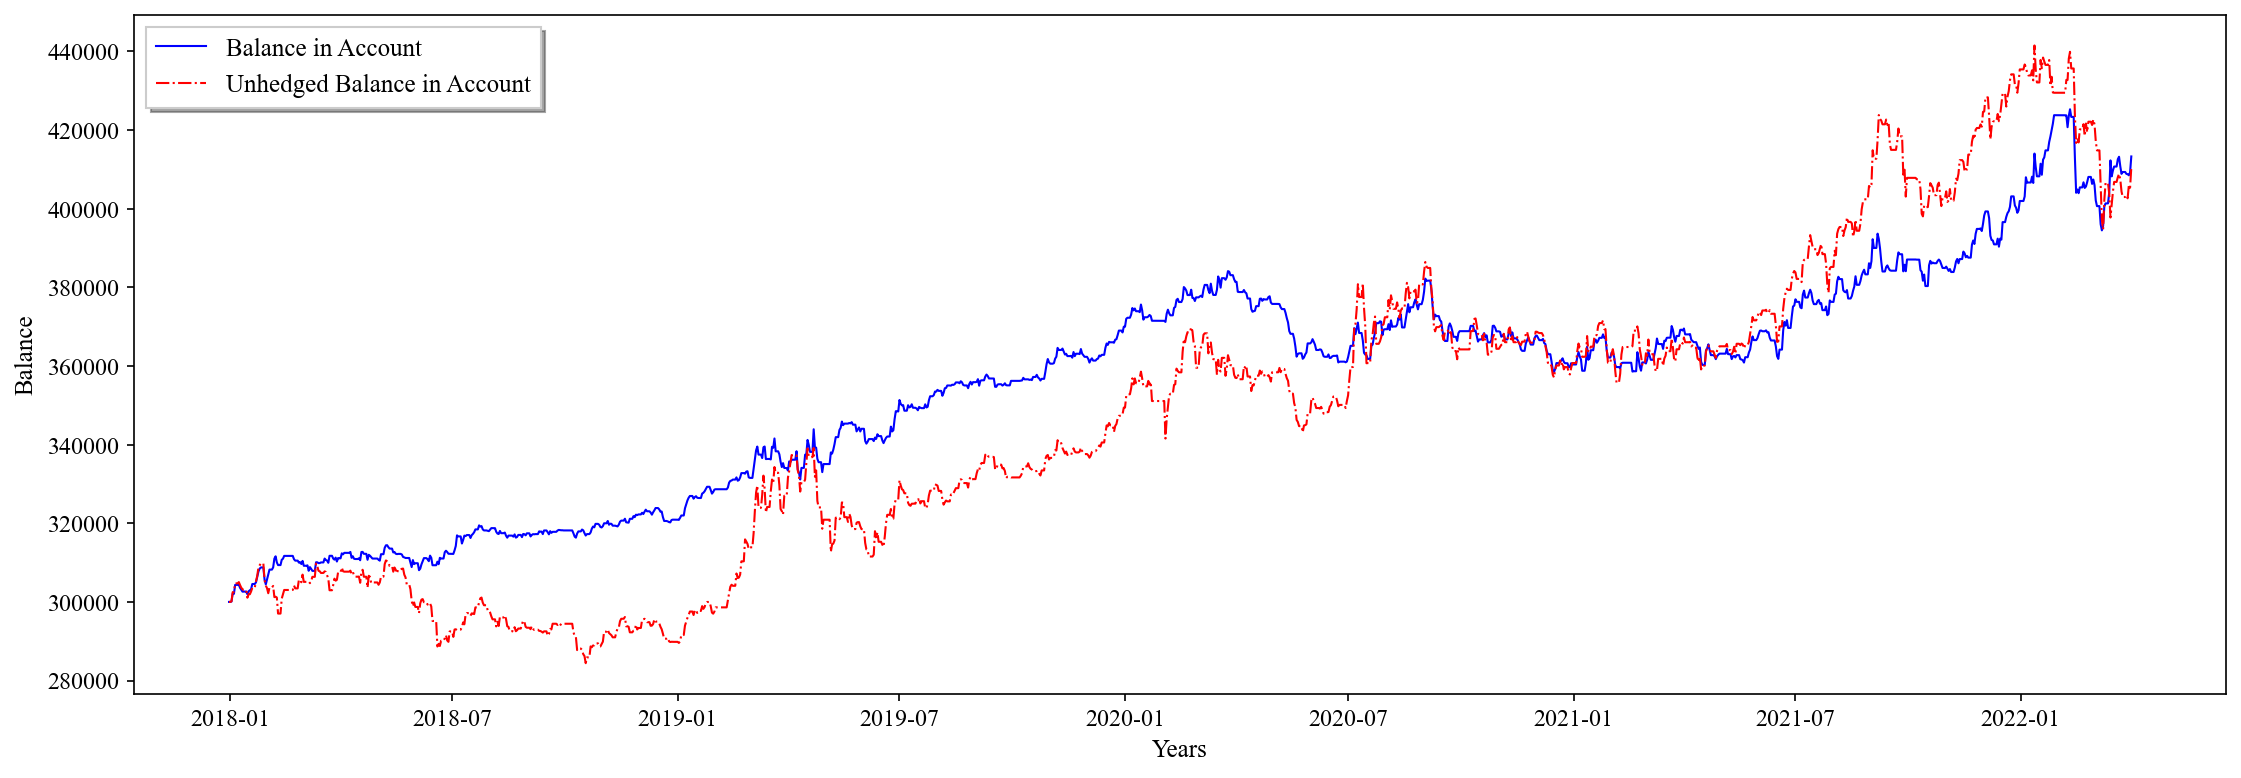

In [25]:
# plot
fig = plt.figure(figsize = (18,6),dpi = 150)
ax1 = fig.add_subplot(111)
ax1.plot(backtest_pnl_result.NET_VALUE, "-",color = "#0000FF",linewidth = 1,label = "Net Value")#非预测对比序列
ax1.plot(backtest_pnl_result.UNHEDGED_NET_VALUE, "-.",color = "red",linewidth = 1,label = "Net Value")#非预测对比序列
plt.xticks(fontproperties='Times New Roman', size = 11.5)
plt.yticks(fontproperties='Times New Roman', size = 11.5)
ax1.set_ylabel("Balance",fontsize = 12)
ax1.set_xlabel("Years",fontsize = 12)
ax1.legend(["Balance in Account","Unhedged Balance in Account"], loc = 'upper left',fontsize = 12,shadow = "gray",fancybox = False)

In [26]:
# Sharpe
rf = 0.00011741094678452413
empyrical.sharpe_ratio(backtest_pnl_result.PNL_RATIO_DAILY.dropna().values, risk_free = rf, period = 'daily', annualization = 365)

0.5058837854359445

In [27]:
# annual return
empyrical.annual_return(backtest_pnl_result.PNL_RATIO_DAILY.dropna().values,period = 'daily',annualization = 365)

0.07534896818294601

In [28]:
# max drawdown
((backtest_pnl_result.NET_VALUE.cummax() - backtest_pnl_result.NET_VALUE)/(backtest_pnl_result.NET_VALUE.cummax())).max()

0.07240214227049449